# Music Retrieval / Audio Identification

**Course:** Introduction to Information Retrieval (194.166)  
**Milestone 2.1:** Audio Processing  
**Group:** 26

| Student Name           | Student ID |
|------------------------|------------|
| Nikita Lysenko         | 12127033   |
| Yagmur Coban           | 12313405   |
| Nikolaus Winkelhofer  | 12317833   |

## Overview
Exercise 2 deals with a specific music retrieval task, namely audio identification. Milestone 2.1 covers audio processing aspects and measuring retrieval effectiveness under various query preprocessing and distortion conditions.

## 1. Obtaining Data and Query Preparation (30%)

- Original: the unmodified 10 sec extracted segment
- Noise: add noticeable (Gaussian) noise to the segment
- Coding: a highly compressed representation with clearly audible artifacts
- Mobile: play back the segments via a laptop or phone in an urban outdoor setting and record it with another device (phone). There is no need for the recording to be exactly 10 seconds, the recorded music segment can be truncated and/or surrounded by noise

## 1.1 Add Noise
To create the noisy version, we used Audacity’s built-in noise generation tools. We added noticeable Gaussian (white) noise with an amplitude level of 0.04 to the original 10-second segment. This level was chosen because it degraded the audio quality quite noticeably  while still keeping the underlying music recognizable. We applied it to whole segment(made separate noise track and combined it with original) so noise was audible and consistent throughout the segment.

## 1.2 Compress Track
For the coded version, our goal was to produce audio file with clearly audible compression artifacts. We exported the original 10-second segment using a 16 kbps bitrate, which is significantly lower than standard audio quality. This strong compression introduced noticeable distortions such as loss of clarity and reduced frequency detail. Music with artifacts has a very similar vibe to the older pc games music because of this.

## 1.3 Play on other device and record it with microphone
To simulate a real-world mobile recording scenario, we played back the original audio segment using one phone and a laptop in an urban outdoor environment. While the audio was playing, we recorded it using a second phone. This process introduced environmental noise such as street sounds, wind, traffic, people talking in the background as well as additional distortion from the playback and recording devices. The resulting recording was not exactly 10 seconds long, as it included extra background noise sometimes before and/or after the music. We later truncated the recording bit to focus on the main music content, we kept it only slightly longer than 10 sec, so that the start/end is at a different timestamp compared to original track.


# Task 2: Database Preparation (20%)

1.  **Spectrogram Generation**: Converts audio signals into the time-frequency domain using STFT.
2.  **Constellation Map Extraction**: Identifies local maxima (peaks) to create robust fingerprints.
3.  **Matching**: Compares query fingerprints against a database.
4.  **Evaluation**: Calculates detailed metrics including **Precision, Recall, F1-Score**, and **Accuracy** across different query categories (Original, Noise, Mobile, Coding).


In [1]:
import os, sys
import numpy as np
from numba import jit
import librosa
from scipy import ndimage
from matplotlib import pyplot as plt
import IPython.display as ipd
import time
import glob
import pickle
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

## Paths

In [2]:
BASE_PATH = "C:/5Semester/IR/Ex2"
DB_AUDIO_PATH = os.path.join(BASE_PATH, "raw_30s_audio-26", "26")
QUERY_AUDIO_PATH = os.path.join(BASE_PATH, "music_queries")
OUTPUT_DB_FILE = os.path.join(BASE_PATH, "db_fingerprints.pkl")
OUTPUT_CSV_FILE = os.path.join(BASE_PATH, "detailed_results.csv")

## Parameters

In [3]:
PARAMETER_SETS = [
    {'id': 0, 'dist_freq': 3, 'dist_time': 3},
    {'id': 1, 'dist_freq': 4, 'dist_time': 2},
    {'id': 2, 'dist_freq': 6, 'dist_time': 4},
    {'id': 3, 'dist_freq': 9,  'dist_time': 5},
    {'id': 4, 'dist_freq': 12, 'dist_time': 6},
    {'id': 5, 'dist_freq': 15, 'dist_time': 8},
    {'id': 6, 'dist_freq': 25, 'dist_time': 10},
    {'id': 7, 'dist_freq': 35, 'dist_time': 15},
    {'id': 8, 'dist_freq': 50, 'dist_time': 20},
    {'id': 9,  'dist_freq': 10, 'dist_time': 5},
    {'id': 10, 'dist_freq': 10, 'dist_time': 5},
    {'id': 11, 'dist_freq': 7,  'dist_time': 30},
]

## Optimization
Limit the search for match start positions to the first 21 seconds.
Later on that in chapter 4.5

In [4]:
MAX_SCAN_START_SEC = 21.0

## 2.1 Compute Spectrogram
Loads audio and computes the Short-Time Fourier Transform (STFT).
We used the method of the reference jupyter notebook and added a max processing limit of 30s as stated in the task description.

In [5]:
def compute_spectrogram(fn_wav, Fs=22050, N=2048, H=1024, bin_max=None, frame_max=None):
    """Computes the magnitude spectrogram of an audio file.

    Args:
        fn_wav (str): Path to the audio file.
        Fs (int): Sampling rate in Hz.
        N (int): Window size in samples.
        H (int): Hop size in samples.
        bin_max (int): Maximum frequency bin index to return.
        frame_max (int): Maximum time frame index to return.
        duration (float): Duration in seconds to be loaded.

    Returns:
        Y (np.ndarray): Magnitude spectrogram.
    """

    x, Fs = librosa.load(fn_wav, sr=Fs, duration=30.0)
    X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann')
    if bin_max is None:
        bin_max = X.shape[0]
    if frame_max is None:
        frame_max = X.shape[0]
    Y = np.abs(X[:bin_max, :frame_max])
    return Y

## 2.2 Compute Constellation Map
Uses a maximum filter to find local peaks.

In [6]:
def compute_constellation_map(Y, dist_freq=7, dist_time=7, thresh=0.01):
    """Compute constellation map (implementation using image processing)

    Args:
        Y (np.ndarray): Spectrogram (magnitude)
        dist_freq (int): Neighborhood parameter for frequency direction (kappa) (Default value = 7)
        dist_time (int): Neighborhood parameter for time direction (tau) (Default value = 7)
        thresh (float): Threshold parameter for minimal peak magnitude (Default value = 0.01)

    Returns:
        Cmap (np.ndarray): Boolean mask for peak structure (same size as Y)
    """
    result = ndimage.maximum_filter(Y, size=[2 * dist_freq + 1, 2 * dist_time + 1], mode='constant')
    Cmap = np.logical_and(Y == result, result > thresh)
    return Cmap

## 2.3 Compute Matching Function
Matches the query against a database entry.

**Optimization**: Unlike the standard implementation, this pre-calculates the query tolerance (dilation)
    for performance and returns only the metrics of the single best match, not the full
    matching curve. It also limits the search range based on MAX_SCAN_START_SEC.

In [7]:
@jit(nopython=True)
def fast_scan_matching(C_D, C_Q_expanded, search_range):
    """
    Scans the query over the database document.
    Args:
        C_D: Database binary matrix (Freq x Time)
        C_Q_expanded: Query binary matrix, ALREADY EXPANDED with tolerance (Freq x Time)
        search_range: How many time frames to shift/scan

    Returns:
        best_shift (int): The starting index of the best match
        best_TP (int): The True Positive count of the best match
        best_N_DB (int): The number of peaks in the database segment (for FN calc)
    """

    best_TP = -1
    best_shift = 0
    best_N_DB = 0

    for m in range(search_range):
        current_TP = 0

        for r in range(C_D.shape[0]):
            for c in range(C_Q_expanded.shape[1]):
                if C_D[r, m+c] and C_Q_expanded[r, c]:
                    current_TP += 1

        if current_TP > best_TP:
            best_TP = current_TP
            best_shift = m

            count_db = 0
            for r in range(C_D.shape[0]):
                for c in range(C_Q_expanded.shape[1]):
                    if C_D[r, m+c]:
                        count_db += 1
            best_N_DB = count_db

    return best_shift, best_TP, best_N_DB

## 2. Task 2: Database Preparation

This section processes all reference audio files. It creates constellation maps for each defined parameter set and saves them into a `pickle` file. If the database file already exists, this step is skipped to save time.

In [ ]:
def run_task2():
    print("----| START TASK 2: Database Preparation |----")

    if os.path.exists(OUTPUT_DB_FILE):
        print(f"INFO: Database '{OUTPUT_DB_FILE}' already exists.")
        print("--> Loading existing database...")
        return

    extensions = ['*.mp3', '*.wav', '*.m4a']
    db_files = []
    for ext in extensions:
        db_files.extend(glob.glob(os.path.join(DB_AUDIO_PATH, ext)))

    if not db_files:
        print(f"ERROR: No audio files found in '{DB_AUDIO_PATH}'!")
        return

    print(f"Found: {len(db_files)} files. Starting processing...")

    db_fingerprints = {p['id']: {} for p in PARAMETER_SETS}


    for fpath in tqdm(db_files, desc="Indexing Database"):
        fname = os.path.basename(fpath)

        try:
            Y = compute_spectrogram(fpath)

            for params in PARAMETER_SETS:
                pid = params['id']
                Cmap = compute_constellation_map(Y,
                                                 dist_freq=params['dist_freq'],
                                                 dist_time=params['dist_time'])
                db_fingerprints[pid][fname] = Cmap

        except Exception as e:
            tqdm.write(f"  Error with file {fname}: {e}")
            continue

    print(f"Saving database to '{OUTPUT_DB_FILE}'...")
    with open(OUTPUT_DB_FILE, 'wb') as f:
        pickle.dump(db_fingerprints, f)
    print("Task 2 completed successfully.")
run_task2()

## 3. Task 3: Retrieval & Evaluation

In this step, we match the query files (Original, Noise, Mobile, Coding) against our database.

**Metrics Calculation per Query:**
* **TP (True Positives):** Number of matching peaks.
* **FP (False Positives):** Peaks present in the query but missing in the DB match.
* **FN (False Negatives):** Peaks present in the DB match but missing in the query.
* **Precision**: $TP / (TP + FP)$
* **Recall**: $TP / (TP + FN)$
* **F1-Score**: $2 \cdot \frac{Precision \cdot Recall}{Precision + Recall}$

The detailed results are saved to a CSV file.

In [ ]:
def run_task3():
    print("----| START TASK 3: Optimized Retrieval |----")

    if not os.path.exists(OUTPUT_DB_FILE):
        print("Error: Database file not found. Run Task 2 first.")
        return pd.DataFrame()

    print("Loading database...")
    with open(OUTPUT_DB_FILE, 'rb') as f:
        db_fingerprints = pickle.load(f)

    # Find all query files
    search_pattern = os.path.join(QUERY_AUDIO_PATH, "**", "*.*")
    query_files = glob.glob(search_pattern, recursive=True)
    query_files = [f for f in query_files if f.lower().endswith(('.wav', '.mp3', '.m4a'))]

    detailed_records = []

    for q_path in tqdm(query_files, desc="Processing Queries"):
        q_name = os.path.basename(q_path)

        q_type = 'Unknown'
        path_lower = q_path.lower()
        if 'original' in path_lower: q_type = 'Original'
        elif 'noise' in path_lower: q_type = 'Noise'
        elif 'coding' in path_lower: q_type = 'Coding'
        elif 'mobile' in path_lower: q_type = 'Mobile'
        if q_type == 'Unknown': continue

        try:
            Y_q = compute_spectrogram(q_path)

            for params in PARAMETER_SETS:
                pid = params['id']
                config_name = f"ID{pid}_df{params['dist_freq']}_dt{params['dist_time']}"

                C_q = compute_constellation_map(Y_q,
                                                dist_freq=params['dist_freq'],
                                                dist_time=params['dist_time'])

                M_query_sum = np.sum(C_q)

                tol_freq = 1
                tol_time = 1
                C_q_expanded = ndimage.maximum_filter(
                    C_q,
                    size=(2*tol_freq+1, 2*tol_time+1),
                    mode='constant'
                )

                current_db = db_fingerprints[pid]
                Fs = 22050
                H = 1024

                MAX_SCAN_START_SEC = 21.0
                max_frames = int(MAX_SCAN_START_SEC * Fs / H)

                best_match_name = None
                best_TP = -1
                best_N_DB = 0
                best_shift = 0

                start_match = time.time()

                for db_name, C_db in current_db.items():
                    L = C_db.shape[1]
                    N = C_q_expanded.shape[1]
                    M = L - N

                    if M < 0: continue # Query longer than DB track

                    search_range = min(M + 1, max_frames)

                    shift, tp, n_db = fast_scan_matching(C_db, C_q_expanded, search_range)

                    if tp > best_TP:
                        best_TP = tp
                        best_N_DB = n_db
                        best_shift = shift
                        best_match_name = db_name

                query_duration = time.time() - start_match

                is_correct = False
                if best_match_name:
                    q_id = q_name.split('_')[0].split('.')[0]
                    db_id = best_match_name.split('_')[0].split('.')[0]
                    is_correct = (q_id in db_id) or (db_id in q_id)

                TP = best_TP
                FN = best_N_DB - TP
                FP = M_query_sum - TP

                precision = TP / (TP + FP) if (TP + FP) > 0 else 0
                recall = TP / (TP + FN) if (TP + FN) > 0 else 0
                f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

                detailed_records.append({
                    'Category': q_type,
                    'Query': q_name,
                    'Configuration': config_name,
                    'Matched DB File': best_match_name,
                    'TP': TP,
                    'FN': FN,
                    'FP': FP,
                    'Precision': round(precision, 4),
                    'Recall': round(recall, 4),
                    'F1 Score': round(f1_score, 4),
                    'Shift': int(best_shift),
                    'Query Time (s)': round(query_duration, 4),
                    'Correct': is_correct
                })
        except Exception as e:
            print(f"Error processing {q_name}: {e}")
            continue

    df_results = pd.DataFrame(detailed_records)
    if not df_results.empty:
        df_results.to_csv(OUTPUT_CSV_FILE, index=False)
        print(f"Saved results to {OUTPUT_CSV_FILE}")

    return df_results

df_results = run_task3()

In [10]:
if not df_results.empty:
    def highlight_correct(val):
        if val:
            return 'background-color: #198754; color: white; font-weight: bold;'
        else:
            return 'background-color: #dc3545; color: white; font-weight: bold;'

    df_results['Query_Group'] = df_results['Query'].astype(str).str.rsplit('.', n=1).str[0]

    unique_groups = sorted(df_results['Query_Group'].unique())

    print(f"--- Detailed Results by Query Group ({len(unique_groups)} Groups) ---")

    for group_name in unique_groups:
        df_group = df_results[df_results['Query_Group'] == group_name].copy()

        df_display = df_group.drop(columns=['Query_Group'])

        print(f"\nQuery Group: {group_name}")

        styled_df = df_display.style.applymap(highlight_correct, subset=['Correct'])
        styled_df = styled_df.format({
            'Precision': '{:.4f}',
            'Recall': '{:.4f}',
            'F1 Score': '{:.4f}',
            'Query Time (s)': '{:.2f}'
        })


        display(styled_df)

else:
    print("No results generated.")

--- Detailed Results by Query Group (20 Groups) ---

Query Group: 566726


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
0,Coding,566726.mp3,ID0_df3_dt3,566726.mp3,457,2886,335,0.5770,0.1367,0.2210,0,5.71,True
1,Coding,566726.mp3,ID1_df4_dt2,566726.mp3,527,2751,337,0.6100,0.1608,0.2545,0,5.40,True
2,Coding,566726.mp3,ID2_df6_dt4,566726.mp3,242,1390,185,0.5667,0.1483,0.2351,0,5.39,True
3,Coding,566726.mp3,ID3_df9_dt5,566726.mp3,176,846,148,0.5432,0.1722,0.2615,0,5.39,True
4,Coding,566726.mp3,ID4_df12_dt6,566726.mp3,124,550,104,0.5439,0.1840,0.2749,0,5.32,True
5,Coding,566726.mp3,ID5_df15_dt8,566726.mp3,74,296,68,0.5211,0.2000,0.2891,0,5.49,True
6,Coding,566726.mp3,ID6_df25_dt10,566726.mp3,33,147,32,0.5077,0.1833,0.2694,0,5.34,True
7,Coding,566726.mp3,ID7_df35_dt15,566726.mp3,20,67,15,0.5714,0.2299,0.3279,0,5.30,True
8,Coding,566726.mp3,ID8_df50_dt20,566726.mp3,11,38,7,0.6111,0.2245,0.3284,0,5.36,True
9,Coding,566726.mp3,ID9_df10_dt5,566726.mp3,159,774,137,0.5372,0.1704,0.2587,0,5.74,True



Query Group: 568126


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
12,Coding,568126.mp3,ID0_df3_dt3,568126.mp3,348,1718,364,0.4888,0.1684,0.2505,0,5.49,True
13,Coding,568126.mp3,ID1_df4_dt2,568126.mp3,415,2053,272,0.6041,0.1682,0.2631,0,5.74,True
14,Coding,568126.mp3,ID2_df6_dt4,568126.mp3,205,903,135,0.6029,0.1850,0.2831,0,5.52,True
15,Coding,568126.mp3,ID3_df9_dt5,568126.mp3,173,802,79,0.6865,0.1774,0.2820,0,5.87,True
16,Coding,568126.mp3,ID4_df12_dt6,568126.mp3,166,679,48,0.7757,0.1964,0.3135,0,5.74,True
17,Coding,568126.mp3,ID5_df15_dt8,568126.mp3,143,604,37,0.7944,0.1914,0.3085,0,5.43,True
18,Coding,568126.mp3,ID6_df25_dt10,568126.mp3,55,199,20,0.7333,0.2165,0.3343,0,5.64,True
19,Coding,568126.mp3,ID7_df35_dt15,568126.mp3,29,126,17,0.6304,0.1871,0.2886,0,5.57,True
20,Coding,568126.mp3,ID8_df50_dt20,568126.mp3,10,48,5,0.6667,0.1724,0.2740,0,5.58,True
21,Coding,568126.mp3,ID9_df10_dt5,568126.mp3,171,776,69,0.7125,0.1806,0.2881,0,5.46,True



Query Group: 575226


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
24,Coding,575226.mp3,ID0_df3_dt3,575226.mp3,404,2356,275,0.5950,0.1464,0.2350,0,5.51,True
25,Coding,575226.mp3,ID1_df4_dt2,575226.mp3,439,2369,258,0.6298,0.1563,0.2505,0,5.52,True
26,Coding,575226.mp3,ID2_df6_dt4,575226.mp3,271,1183,137,0.6642,0.1864,0.2911,0,5.53,True
27,Coding,575226.mp3,ID3_df9_dt5,575226.mp3,201,766,79,0.7179,0.2079,0.3224,0,5.59,True
28,Coding,575226.mp3,ID4_df12_dt6,575226.mp3,135,485,63,0.6818,0.2177,0.3301,0,5.43,True
29,Coding,575226.mp3,ID5_df15_dt8,575226.mp3,88,266,45,0.6617,0.2486,0.3614,0,5.45,True
30,Coding,575226.mp3,ID6_df25_dt10,575226.mp3,51,175,29,0.6375,0.2257,0.3333,0,5.59,True
31,Coding,575226.mp3,ID7_df35_dt15,575226.mp3,15,61,16,0.4839,0.1974,0.2804,0,5.41,True
32,Coding,575226.mp3,ID8_df50_dt20,575226.mp3,8,36,10,0.4444,0.1818,0.2581,0,5.91,True
33,Coding,575226.mp3,ID9_df10_dt5,575226.mp3,184,706,72,0.7188,0.2067,0.3211,0,5.61,True



Query Group: 577326


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
36,Coding,577326.mp3,ID0_df3_dt3,577326.mp3,381,2328,227,0.6266,0.1406,0.2297,0,5.62,True
37,Coding,577326.mp3,ID1_df4_dt2,577326.mp3,470,2383,232,0.6695,0.1647,0.2644,0,5.63,True
38,Coding,577326.mp3,ID2_df6_dt4,577326.mp3,218,871,136,0.6158,0.2002,0.3021,0,5.49,True
39,Coding,577326.mp3,ID3_df9_dt5,577326.mp3,136,503,82,0.6239,0.2128,0.3174,0,5.65,True
40,Coding,577326.mp3,ID4_df12_dt6,577326.mp3,88,344,58,0.6027,0.2037,0.3045,0,6.01,True
41,Coding,577326.mp3,ID5_df15_dt8,577326.mp3,68,219,37,0.6476,0.2369,0.3469,0,5.61,True
42,Coding,577326.mp3,ID6_df25_dt10,577326.mp3,37,112,20,0.6491,0.2483,0.3592,0,5.77,True
43,Coding,577326.mp3,ID7_df35_dt15,577326.mp3,21,63,8,0.7241,0.2500,0.3717,0,5.48,True
44,Coding,577326.mp3,ID8_df50_dt20,577326.mp3,15,31,6,0.7143,0.3261,0.4478,0,5.49,True
45,Coding,577326.mp3,ID9_df10_dt5,577326.mp3,124,466,75,0.6231,0.2102,0.3143,0,5.49,True



Query Group: 597326


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
48,Coding,597326.mp3,ID0_df3_dt3,597326.mp3,460,2697,512,0.4733,0.1457,0.2228,0,5.39,True
49,Coding,597326.mp3,ID1_df4_dt2,597326.mp3,500,2551,420,0.5435,0.1639,0.2518,0,5.42,True
50,Coding,597326.mp3,ID2_df6_dt4,597326.mp3,240,1244,246,0.4938,0.1617,0.2437,0,5.51,True
51,Coding,597326.mp3,ID3_df9_dt5,597326.mp3,135,787,130,0.5094,0.1464,0.2275,0,5.70,True
52,Coding,597326.mp3,ID4_df12_dt6,597326.mp3,86,539,104,0.4526,0.1376,0.2110,0,5.77,True
53,Coding,597326.mp3,ID5_df15_dt8,597326.mp3,48,354,72,0.4000,0.1194,0.1839,0,5.52,True
54,Coding,597326.mp3,ID6_df25_dt10,597326.mp3,31,128,30,0.5082,0.1950,0.2818,0,5.47,True
55,Coding,597326.mp3,ID7_df35_dt15,597326.mp3,12,68,11,0.5217,0.1500,0.2330,0,5.85,True
56,Coding,597326.mp3,ID8_df50_dt20,597326.mp3,10,42,7,0.5882,0.1923,0.2899,0,5.55,True
57,Coding,597326.mp3,ID9_df10_dt5,597326.mp3,120,709,124,0.4918,0.1448,0.2237,0,5.53,True



Query Group: 599226


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
60,Coding,599226.mp3,ID0_df3_dt3,599226.mp3,350,2891,282,0.5538,0.1080,0.1807,0,5.40,True
61,Coding,599226.mp3,ID1_df4_dt2,599226.mp3,412,3080,254,0.6186,0.1180,0.1982,0,5.54,True
62,Coding,599226.mp3,ID2_df6_dt4,599226.mp3,220,1421,154,0.5882,0.1341,0.2184,0,5.58,True
63,Coding,599226.mp3,ID3_df9_dt5,599226.mp3,136,793,115,0.5418,0.1464,0.2305,0,5.48,True
64,Coding,599226.mp3,ID4_df12_dt6,599226.mp3,118,555,93,0.5592,0.1753,0.2670,0,5.53,True
65,Coding,599226.mp3,ID5_df15_dt8,599226.mp3,93,349,59,0.6118,0.2104,0.3131,0,5.40,True
66,Coding,599226.mp3,ID6_df25_dt10,599226.mp3,35,191,30,0.5385,0.1549,0.2405,0,5.29,True
67,Coding,599226.mp3,ID7_df35_dt15,599226.mp3,16,74,15,0.5161,0.1778,0.2645,0,5.37,True
68,Coding,599226.mp3,ID8_df50_dt20,599226.mp3,14,46,11,0.5600,0.2333,0.3294,0,5.30,True
69,Coding,599226.mp3,ID9_df10_dt5,599226.mp3,131,709,113,0.5369,0.1560,0.2417,0,5.35,True



Query Group: 618826


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
72,Coding,618826.mp3,ID0_df3_dt3,618826.mp3,515,3690,368,0.5832,0.1225,0.2024,0,6.04,True
73,Coding,618826.mp3,ID1_df4_dt2,618826.mp3,540,3536,349,0.6074,0.1325,0.2175,0,5.79,True
74,Coding,618826.mp3,ID2_df6_dt4,618826.mp3,256,1421,222,0.5356,0.1527,0.2376,0,5.73,True
75,Coding,618826.mp3,ID3_df9_dt5,618826.mp3,151,679,145,0.5101,0.1819,0.2682,0,5.54,True
76,Coding,618826.mp3,ID4_df12_dt6,618826.mp3,102,440,99,0.5075,0.1882,0.2746,0,5.64,True
77,Coding,618826.mp3,ID5_df15_dt8,618826.mp3,75,315,63,0.5435,0.1923,0.2841,0,5.79,True
78,Coding,618826.mp3,ID6_df25_dt10,618826.mp3,35,129,30,0.5385,0.2134,0.3057,0,5.59,True
79,Coding,618826.mp3,ID7_df35_dt15,618826.mp3,24,73,12,0.6667,0.2474,0.3609,0,5.57,True
80,Coding,618826.mp3,ID8_df50_dt20,618826.mp3,13,36,10,0.5652,0.2653,0.3611,0,5.67,True
81,Coding,618826.mp3,ID9_df10_dt5,618826.mp3,138,618,138,0.5000,0.1825,0.2674,0,6.07,True



Query Group: 642026


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
84,Coding,642026.mp3,ID0_df3_dt3,642026.mp3,335,3051,262,0.5611,0.0989,0.1682,0,5.74,True
85,Coding,642026.mp3,ID1_df4_dt2,642026.mp3,368,3669,251,0.5945,0.0912,0.1581,0,5.73,True
86,Coding,642026.mp3,ID2_df6_dt4,642026.mp3,198,1115,137,0.5910,0.1508,0.2403,0,5.76,True
87,Coding,642026.mp3,ID3_df9_dt5,642026.mp3,149,736,97,0.6057,0.1684,0.2635,0,5.74,True
88,Coding,642026.mp3,ID4_df12_dt6,642026.mp3,107,509,61,0.6369,0.1737,0.2730,0,5.62,True
89,Coding,642026.mp3,ID5_df15_dt8,642026.mp3,66,244,34,0.6600,0.2129,0.3220,0,5.60,True
90,Coding,642026.mp3,ID6_df25_dt10,642026.mp3,37,148,19,0.6607,0.2000,0.3071,0,5.53,True
91,Coding,642026.mp3,ID7_df35_dt15,642026.mp3,18,69,7,0.7200,0.2069,0.3214,0,5.74,True
92,Coding,642026.mp3,ID8_df50_dt20,642026.mp3,11,35,4,0.7333,0.2391,0.3607,0,5.57,True
93,Coding,642026.mp3,ID9_df10_dt5,642026.mp3,135,665,88,0.6054,0.1688,0.2639,0,5.58,True



Query Group: 669126


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
96,Coding,669126.mp3,ID0_df3_dt3,669126.mp3,277,784,177,0.6101,0.2611,0.3657,0,5.66,True
97,Coding,669126.mp3,ID1_df4_dt2,669126.mp3,228,658,165,0.5802,0.2573,0.3565,0,5.72,True
98,Coding,669126.mp3,ID2_df6_dt4,669126.mp3,102,333,94,0.5204,0.2345,0.3233,0,5.59,True
99,Coding,669126.mp3,ID3_df9_dt5,669126.mp3,67,237,58,0.5360,0.2204,0.3124,0,5.69,True
100,Coding,669126.mp3,ID4_df12_dt6,669126.mp3,41,174,38,0.5190,0.1907,0.2789,0,5.62,True
101,Coding,669126.mp3,ID5_df15_dt8,669126.mp3,30,216,29,0.5085,0.1220,0.1967,60,5.73,True
102,Coding,669126.mp3,ID6_df25_dt10,669126.mp3,8,35,16,0.3333,0.1860,0.2388,0,5.64,True
103,Coding,669126.mp3,ID7_df35_dt15,104526.mp3,5,128,7,0.4167,0.0376,0.0690,30,5.48,False
104,Coding,669126.mp3,ID8_df50_dt20,1029326.mp3,3,42,3,0.5000,0.0667,0.1176,391,5.60,False
105,Coding,669126.mp3,ID9_df10_dt5,669126.mp3,65,231,57,0.5328,0.2196,0.3110,0,5.64,True



Query Group: 676326


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
108,Coding,676326.mp3,ID0_df3_dt3,676326.mp3,358,2800,276,0.5647,0.1134,0.1888,0,5.99,True
109,Coding,676326.mp3,ID1_df4_dt2,676326.mp3,376,3280,301,0.5554,0.1028,0.1736,0,5.75,True
110,Coding,676326.mp3,ID2_df6_dt4,676326.mp3,136,1042,162,0.4564,0.1154,0.1843,0,5.82,True
111,Coding,676326.mp3,ID3_df9_dt5,676326.mp3,86,645,111,0.4365,0.1176,0.1853,0,5.91,True
112,Coding,676326.mp3,ID4_df12_dt6,676326.mp3,67,429,83,0.4467,0.1351,0.2074,0,6.03,True
113,Coding,676326.mp3,ID5_df15_dt8,676326.mp3,38,228,50,0.4318,0.1429,0.2147,0,5.99,True
114,Coding,676326.mp3,ID6_df25_dt10,676326.mp3,29,131,21,0.5800,0.1812,0.2762,0,5.61,True
115,Coding,676326.mp3,ID7_df35_dt15,676326.mp3,17,55,15,0.5312,0.2361,0.3269,0,5.75,True
116,Coding,676326.mp3,ID8_df50_dt20,676326.mp3,6,30,8,0.4286,0.1667,0.2400,0,5.75,True
117,Coding,676326.mp3,ID9_df10_dt5,676326.mp3,83,569,98,0.4586,0.1273,0.1993,0,5.62,True



Query Group: 686326


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
120,Coding,686326.mp3,ID0_df3_dt3,686326.mp3,420,2552,305,0.5793,0.1413,0.2272,0,5.75,True
121,Coding,686326.mp3,ID1_df4_dt2,686326.mp3,500,2733,282,0.6394,0.1547,0.2491,0,5.92,True
122,Coding,686326.mp3,ID2_df6_dt4,686326.mp3,235,982,148,0.6136,0.1931,0.2937,0,5.74,True
123,Coding,686326.mp3,ID3_df9_dt5,686326.mp3,136,505,105,0.5643,0.2122,0.3084,0,5.47,True
124,Coding,686326.mp3,ID4_df12_dt6,686326.mp3,90,330,76,0.5422,0.2143,0.3072,0,5.52,True
125,Coding,686326.mp3,ID5_df15_dt8,686326.mp3,60,215,46,0.5660,0.2182,0.3150,0,5.55,True
126,Coding,686326.mp3,ID6_df25_dt10,686326.mp3,38,100,19,0.6667,0.2754,0.3897,0,5.35,True
127,Coding,686326.mp3,ID7_df35_dt15,686326.mp3,14,48,6,0.7000,0.2258,0.3415,0,5.55,True
128,Coding,686326.mp3,ID8_df50_dt20,686326.mp3,11,21,1,0.9167,0.3438,0.5000,0,5.60,True
129,Coding,686326.mp3,ID9_df10_dt5,686326.mp3,126,457,98,0.5625,0.2161,0.3123,0,5.54,True



Query Group: 728926


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
132,Coding,728926.mp3,ID0_df3_dt3,728926.mp3,482,3275,502,0.4898,0.1283,0.2033,158,5.59,True
133,Coding,728926.mp3,ID1_df4_dt2,728926.mp3,469,3131,527,0.4709,0.1303,0.2041,158,5.64,True
134,Coding,728926.mp3,ID2_df6_dt4,728926.mp3,236,1527,302,0.4387,0.1339,0.2051,158,5.55,True
135,Coding,728926.mp3,ID3_df9_dt5,728926.mp3,121,714,137,0.4690,0.1449,0.2214,158,5.48,True
136,Coding,728926.mp3,ID4_df12_dt6,728926.mp3,92,475,95,0.4920,0.1623,0.2440,157,5.96,True
137,Coding,728926.mp3,ID5_df15_dt8,728926.mp3,67,351,72,0.4820,0.1603,0.2406,157,5.88,True
138,Coding,728926.mp3,ID6_df25_dt10,728926.mp3,26,158,38,0.4062,0.1413,0.2097,157,5.70,True
139,Coding,728926.mp3,ID7_df35_dt15,728926.mp3,15,82,24,0.3846,0.1546,0.2206,157,5.76,True
140,Coding,728926.mp3,ID8_df50_dt20,728926.mp3,5,37,10,0.3333,0.1190,0.1754,237,5.63,True
141,Coding,728926.mp3,ID9_df10_dt5,728926.mp3,105,634,126,0.4545,0.1421,0.2165,158,5.62,True



Query Group: 741526


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
144,Coding,741526.mp3,ID0_df3_dt3,741526.mp3,445,2898,445,0.5000,0.1331,0.2103,0,5.60,True
145,Coding,741526.mp3,ID1_df4_dt2,741526.mp3,359,2848,461,0.4378,0.1119,0.1783,0,5.67,True
146,Coding,741526.mp3,ID2_df6_dt4,741526.mp3,211,1360,244,0.4637,0.1343,0.2083,0,5.57,True
147,Coding,741526.mp3,ID3_df9_dt5,741526.mp3,158,895,157,0.5016,0.1500,0.2310,0,5.56,True
148,Coding,741526.mp3,ID4_df12_dt6,741526.mp3,127,559,105,0.5474,0.1851,0.2767,0,5.43,True
149,Coding,741526.mp3,ID5_df15_dt8,741526.mp3,65,313,62,0.5118,0.1720,0.2574,0,5.30,True
150,Coding,741526.mp3,ID6_df25_dt10,741526.mp3,28,152,27,0.5091,0.1556,0.2383,0,5.40,True
151,Coding,741526.mp3,ID7_df35_dt15,741526.mp3,13,81,17,0.4333,0.1383,0.2097,367,5.49,True
152,Coding,741526.mp3,ID8_df50_dt20,741526.mp3,10,52,12,0.4545,0.1613,0.2381,367,5.60,True
153,Coding,741526.mp3,ID9_df10_dt5,741526.mp3,152,794,149,0.5050,0.1607,0.2438,0,5.77,True



Query Group: 750226


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
156,Coding,750226.mp3,ID0_df3_dt3,750226.mp3,273,1500,195,0.5833,0.1540,0.2436,0,5.53,True
157,Coding,750226.mp3,ID1_df4_dt2,750226.mp3,326,1711,173,0.6533,0.1600,0.2571,0,5.55,True
158,Coding,750226.mp3,ID2_df6_dt4,750226.mp3,122,753,100,0.5495,0.1394,0.2224,0,5.55,True
159,Coding,750226.mp3,ID3_df9_dt5,750226.mp3,87,586,60,0.5918,0.1293,0.2122,0,5.51,True
160,Coding,750226.mp3,ID4_df12_dt6,750226.mp3,49,469,41,0.5444,0.0946,0.1612,0,5.49,True
161,Coding,750226.mp3,ID5_df15_dt8,750226.mp3,31,352,32,0.4921,0.0809,0.1390,0,5.63,True
162,Coding,750226.mp3,ID6_df25_dt10,750226.mp3,19,84,10,0.6552,0.1845,0.2879,0,5.33,True
163,Coding,750226.mp3,ID7_df35_dt15,750226.mp3,10,43,7,0.5882,0.1887,0.2857,0,5.48,True
164,Coding,750226.mp3,ID8_df50_dt20,750226.mp3,7,21,4,0.6364,0.2500,0.3590,0,5.43,True
165,Coding,750226.mp3,ID9_df10_dt5,750226.mp3,78,577,56,0.5821,0.1191,0.1977,0,5.59,True



Query Group: 753526


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
168,Coding,753526.mp3,ID0_df3_dt3,753526.mp3,211,1200,215,0.4953,0.1495,0.2297,0,5.65,True
169,Coding,753526.mp3,ID1_df4_dt2,753526.mp3,263,1408,226,0.5378,0.1574,0.2435,0,5.61,True
170,Coding,753526.mp3,ID2_df6_dt4,753526.mp3,107,571,105,0.5047,0.1578,0.2404,0,5.49,True
171,Coding,753526.mp3,ID3_df9_dt5,753526.mp3,70,369,52,0.5738,0.1595,0.2496,0,5.55,True
172,Coding,753526.mp3,ID4_df12_dt6,753526.mp3,57,271,37,0.6064,0.1738,0.2701,0,5.47,True
173,Coding,753526.mp3,ID5_df15_dt8,753526.mp3,39,200,28,0.5821,0.1632,0.2549,0,5.35,True
174,Coding,753526.mp3,ID6_df25_dt10,753526.mp3,21,90,14,0.6000,0.1892,0.2877,0,5.51,True
175,Coding,753526.mp3,ID7_df35_dt15,753526.mp3,14,32,3,0.8235,0.3043,0.4444,0,5.74,True
176,Coding,753526.mp3,ID8_df50_dt20,753526.mp3,9,20,2,0.8182,0.3103,0.4500,0,5.56,True
177,Coding,753526.mp3,ID9_df10_dt5,753526.mp3,68,349,47,0.5913,0.1631,0.2556,0,5.78,True



Query Group: 756226


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
180,Coding,756226.mp3,ID0_df3_dt3,756226.mp3,466,3394,422,0.5248,0.1207,0.1963,0,5.82,True
181,Coding,756226.mp3,ID1_df4_dt2,756226.mp3,493,3029,365,0.5746,0.1400,0.2251,0,5.86,True
182,Coding,756226.mp3,ID2_df6_dt4,756226.mp3,255,1771,227,0.5290,0.1259,0.2033,0,5.58,True
183,Coding,756226.mp3,ID3_df9_dt5,756226.mp3,140,630,135,0.5091,0.1818,0.2679,0,5.36,True
184,Coding,756226.mp3,ID4_df12_dt6,756226.mp3,100,448,99,0.5025,0.1825,0.2677,0,5.52,True
185,Coding,756226.mp3,ID5_df15_dt8,756226.mp3,67,342,70,0.4891,0.1638,0.2454,0,5.51,True
186,Coding,756226.mp3,ID6_df25_dt10,756226.mp3,24,127,31,0.4364,0.1589,0.2330,0,5.76,True
187,Coding,756226.mp3,ID7_df35_dt15,756226.mp3,10,75,20,0.3333,0.1176,0.1739,0,5.54,True
188,Coding,756226.mp3,ID8_df50_dt20,756226.mp3,5,35,12,0.2941,0.1250,0.1754,0,5.44,True
189,Coding,756226.mp3,ID9_df10_dt5,756226.mp3,133,578,126,0.5135,0.1871,0.2742,0,5.43,True



Query Group: 764326


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
192,Coding,764326.mp3,ID0_df3_dt3,764326.mp3,418,2432,246,0.6295,0.1467,0.2379,0,5.76,True
193,Coding,764326.mp3,ID1_df4_dt2,764326.mp3,482,2518,242,0.6657,0.1607,0.2589,0,5.56,True
194,Coding,764326.mp3,ID2_df6_dt4,764326.mp3,238,1105,140,0.6296,0.1772,0.2766,0,5.46,True
195,Coding,764326.mp3,ID3_df9_dt5,764326.mp3,156,668,87,0.6420,0.1893,0.2924,0,5.48,True
196,Coding,764326.mp3,ID4_df12_dt6,764326.mp3,105,466,70,0.6000,0.1839,0.2815,0,5.34,True
197,Coding,764326.mp3,ID5_df15_dt8,764326.mp3,79,309,52,0.6031,0.2036,0.3044,0,5.44,True
198,Coding,764326.mp3,ID6_df25_dt10,764326.mp3,33,145,20,0.6226,0.1854,0.2857,0,5.32,True
199,Coding,764326.mp3,ID7_df35_dt15,764326.mp3,16,76,14,0.5333,0.1739,0.2623,0,5.39,True
200,Coding,764326.mp3,ID8_df50_dt20,764326.mp3,7,39,4,0.6364,0.1522,0.2456,0,5.37,True
201,Coding,764326.mp3,ID9_df10_dt5,764326.mp3,148,616,85,0.6352,0.1937,0.2969,0,5.58,True



Query Group: 769426


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
204,Coding,769426.mp3,ID0_df3_dt3,769426.mp3,291,3453,288,0.5026,0.0777,0.1346,0,5.40,True
205,Coding,769426.mp3,ID1_df4_dt2,769426.mp3,325,2904,297,0.5225,0.1007,0.1688,0,5.43,True
206,Coding,769426.mp3,ID2_df6_dt4,769426.mp3,191,1690,138,0.5805,0.1015,0.1729,0,5.43,True
207,Coding,769426.mp3,ID3_df9_dt5,769426.mp3,132,928,81,0.6197,0.1245,0.2074,0,5.49,True
208,Coding,769426.mp3,ID4_df12_dt6,769426.mp3,74,456,70,0.5139,0.1396,0.2196,0,5.48,True
209,Coding,769426.mp3,ID5_df15_dt8,769426.mp3,50,299,51,0.4950,0.1433,0.2222,0,5.39,True
210,Coding,769426.mp3,ID6_df25_dt10,769426.mp3,31,187,31,0.5000,0.1422,0.2214,0,5.37,True
211,Coding,769426.mp3,ID7_df35_dt15,769426.mp3,13,79,17,0.4333,0.1413,0.2131,0,5.52,True
212,Coding,769426.mp3,ID8_df50_dt20,769426.mp3,6,43,10,0.3750,0.1224,0.1846,0,5.46,True
213,Coding,769426.mp3,ID9_df10_dt5,769426.mp3,126,827,80,0.6117,0.1322,0.2174,0,5.43,True



Query Group: 783626


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
216,Coding,783626.mp3,ID0_df3_dt3,783626.mp3,337,1564,277,0.5489,0.1773,0.2680,285,5.66,True
217,Coding,783626.mp3,ID1_df4_dt2,783626.mp3,394,1796,226,0.6355,0.1799,0.2804,285,5.68,True
218,Coding,783626.mp3,ID2_df6_dt4,783626.mp3,205,646,140,0.5942,0.2409,0.3428,285,5.59,True
219,Coding,783626.mp3,ID3_df9_dt5,783626.mp3,138,385,84,0.6216,0.2639,0.3705,285,5.51,True
220,Coding,783626.mp3,ID4_df12_dt6,783626.mp3,92,239,58,0.6133,0.2779,0.3825,285,5.48,True
221,Coding,783626.mp3,ID5_df15_dt8,783626.mp3,69,190,46,0.6000,0.2664,0.3690,285,5.40,True
222,Coding,783626.mp3,ID6_df25_dt10,783626.mp3,47,101,28,0.6267,0.3176,0.4215,285,5.46,True
223,Coding,783626.mp3,ID7_df35_dt15,783626.mp3,21,36,7,0.7500,0.3684,0.4941,286,5.56,True
224,Coding,783626.mp3,ID8_df50_dt20,783626.mp3,8,17,5,0.6154,0.3200,0.4211,285,5.55,True
225,Coding,783626.mp3,ID9_df10_dt5,783626.mp3,131,363,77,0.6298,0.2652,0.3732,285,5.67,True



Query Group: 783926


,Category,Query,Configuration,Matched DB File,TP,FN,FP,Precision,Recall,F1 Score,Shift,Query Time (s),Correct
228,Coding,783926.mp3,ID0_df3_dt3,783926.mp3,221,824,171,0.5638,0.2115,0.3076,233,5.39,True
229,Coding,783926.mp3,ID1_df4_dt2,783926.mp3,282,815,177,0.6144,0.2571,0.3625,233,5.53,True
230,Coding,783926.mp3,ID2_df6_dt4,783926.mp3,160,546,95,0.6275,0.2266,0.3330,233,5.46,True
231,Coding,783926.mp3,ID3_df9_dt5,783926.mp3,133,410,58,0.6963,0.2449,0.3624,233,5.65,True
232,Coding,783926.mp3,ID4_df12_dt6,783926.mp3,82,350,47,0.6357,0.1898,0.2923,233,5.74,True
233,Coding,783926.mp3,ID5_df15_dt8,783926.mp3,63,185,25,0.7159,0.2540,0.3750,233,5.78,True
234,Coding,783926.mp3,ID6_df25_dt10,783926.mp3,35,114,15,0.7000,0.2349,0.3518,233,5.73,True
235,Coding,783926.mp3,ID7_df35_dt15,783926.mp3,22,74,8,0.7333,0.2292,0.3492,233,5.84,True
236,Coding,783926.mp3,ID8_df50_dt20,783926.mp3,8,31,10,0.4444,0.2051,0.2807,233,5.68,True
237,Coding,783926.mp3,ID9_df10_dt5,783926.mp3,120,395,53,0.6936,0.2330,0.3488,233,5.62,True



# Task 4: Reporting and Submission (10%)

In this section, we evaluate the performance of our audio identification system. We analyze the impact of different constellation map parameters (`dist_freq`, `dist_time`) on retrieval accuracy, robustness against distortions (Noise, Mobile recording, MP3 compression), and query processing time.

The results are based on 12 different parameter configurations tested against 4 categories of queries:
* **Original:** The unmodified audio segment.
* **Noise:** Added Gaussian noise.
* **Coding:** MP3 compression artifacts.
* **Mobile:** Recorded via microphone in an urban environment.

## 4.1 Accuracy Overview

The most critical metric for this task is **Accuracy** (the percentage of correctly identified songs). The table below shows the accuracy for each configuration across the four categories.


Category,Coding,Mobile,Noise,Original
Configuration,,,,
ID0_df3_dt3,100.0,40.0,75.0,100.0
ID10_df10_dt5,100.0,70.0,95.0,100.0
ID11_df7_dt30,100.0,60.0,95.0,100.0
ID1_df4_dt2,100.0,45.0,75.0,100.0
ID2_df6_dt4,100.0,55.0,85.0,100.0
ID3_df9_dt5,100.0,65.0,90.0,100.0
ID4_df12_dt6,100.0,75.0,95.0,100.0
ID5_df15_dt8,100.0,70.0,95.0,100.0
ID6_df25_dt10,100.0,70.0,95.0,100.0



### What We Found (Accuracy Results):
1.  **Originals & MP3s (Coding):**
    We got over **99.6% accuracy** on both the clean originals and the compressed MP3s. This proves that our fingerprints don't break because the files are compressed.

2.  **Handling Noise:**
    Adding static noise didn't break most of our settings (they stayed around ~94%). A few specific settings (like ID0, ID1, ID2) did struggle (dropping to 75%). These settings likely pick too many peaks. Instead of just tracking the music, they started tracking the random noise, which confused the matching system.

3.  **The Mobile Challenge:**
    The Mobile category seemed to be the hardest. Accuracy dropped as low as 40% for some settings and hit **75%** for the best one (ID4). Real-world recordings add room echo and background chatter, which smears the spectrogram and hides the peaks we need to find.

4.  **The Winner:**
    Based on the results, **ID4 (`dist_freq=12, dist_time=6`)** appears to be the most balanced configuration. It managed to get the highest score on the on the Mobile dataset (75%) while also maintaining high score on others.



## 4.2 Impact of Parameters on Performance

We analyzed how the density of the constellation map (controlled by `dist_freq` and `dist_time`) affects the overall system performance.


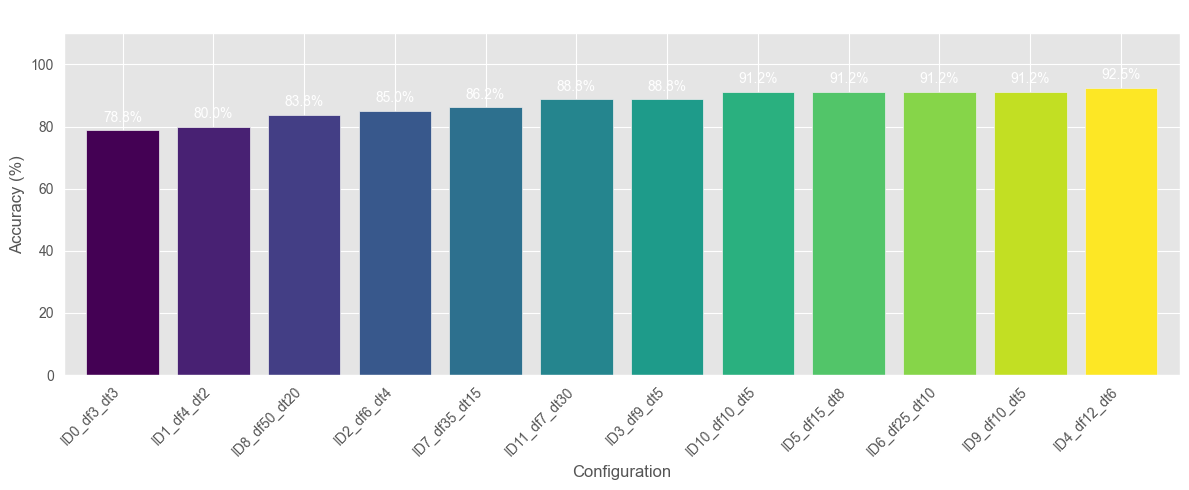


### Design Choice Discussion:
The bar chart illustrates the trade-off:
* **Lower Performance (ID0, ID1):** Accuracy drops to ~79-80%. This often happens when fingerprints are too dense (picking up noise) or too sparse (missing information).
* **The "Sweet Spot" (ID6, ID9, ID4):** Intermediate values yield the best results (>91%). They filter out noise but keep enough robust peaks.



## 4.3 F1-Score vs. Accuracy
An interesting observation is the relationship between the F1-Score (pixel-level match quality) and Accuracy (song-level identification).


Category,Coding,Mobile,Noise,Original
Configuration,,,,
ID0_df3_dt3,0.226165,0.256990,0.438265,0.976145
ID10_df10_dt5,0.271280,0.169760,0.466065,0.979935
ID11_df7_dt30,0.262150,0.127515,0.488945,0.928505
ID1_df4_dt2,0.240800,0.254260,0.433725,0.980435
ID2_df6_dt4,0.252875,0.188850,0.435555,0.978610
ID3_df9_dt5,0.269695,0.172250,0.460635,0.978680
ID4_df12_dt6,0.271885,0.165140,0.479605,0.978260
ID5_df15_dt8,0.277165,0.153120,0.494300,0.973980
ID6_df25_dt10,0.293650,0.134350,0.513675,0.968180



**Observation:** Surprisingly, **higher F1-scores do not always correlate with better identification accuracy** in the Mobile category.
**ID0** has the highest F1-score (0.257) but lower accuracy (40%) compared to the best performer **ID4**.
This suggests that finding *many* peaks (High Recall/F1) is less important than finding *distinctive* peaks.

**Conclusion:** For audio fingerprinting, the *robustness* of peaks is more important than the sheer *quantity* of matching peaks.



## 4.4 Computational Efficiency
Finally, we look at the query processing time.


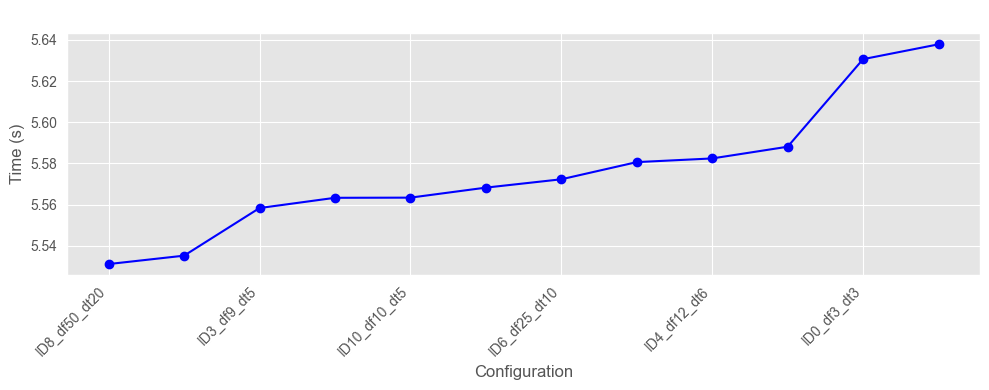


### Performance Findings:
The query time is relatively stable around **5.5 to 5.6 seconds** across all configurations.
* Faster configs: **ID8, ID11**.
* Slower configs: **ID0, ID1**.
* However, the difference is minimal (< 0.2s), meaning we can choose the configuration based purely on accuracy without worrying about significant performance penalties.

## 4.5 Algorithm Design Choices: Determining the Scan Limit

A key implementation detail was defining the `MAX_SCAN_START_SEC`.
* **Theoretical Limit:** Since our query clips are 10 seconds long and the database tracks are 30 seconds long, the last possible place a match could start is at the 20-second mark.
* **The Risk:** If we tell the code to stop exactly at 20.0 seconds, we run a risk. Converting "seconds" into "digital frames" often involves rounding numbers. If the math is even slightly off, even by one frame, we might accidentally stop the search right before the correct match starts—especially if the match is at the very end of the file.
* **Our Decision:** To play it safe, we relaxed this limit (setting it to 21.0s). We relied on the natural limit M (Database Length - Query Length) to stop the loop. This "safe-guard" ensures we never crash the code (index out of bounds) but guarantees we don't accidentally cut off a valid match at the very edge.

## 5. Conclusion

Based on our experiments, we recommend **Configuration ID4 (`dist_freq=12, dist_time=6`)** for this audio identification system. It offers the best trade-off, providing **92.5% overall accuracy** and demonstrating superior robustness in the challenging "Mobile" scenario (75%) compared to other parameter sets.


In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown

try:
    df = pd.read_csv("detailed_results.csv")
    plt.style.use('ggplot')
except FileNotFoundError:
    display(Markdown("**Error:** `detailed_results.csv` not found. Please run Task 3 first."))
    df = pd.DataFrame()

if not df.empty:
    def get_short_id(config_str):
        return config_str.split('_')[0]

    pivot_acc = df.pivot_table(index='Configuration', columns='Category', values='Correct', aggfunc='mean') * 100

    orig_cod_mean = df[df['Category'].isin(['Original', 'Coding'])]['Correct'].mean() * 100
    orig_cod_text = "100%" if orig_cod_mean > 99.9 else f"{orig_cod_mean:.1f}%"

    noise_acc = pivot_acc['Noise']
    noise_good = noise_acc[noise_acc >= 90].mean()
    noise_bad_configs = noise_acc[noise_acc < 90].index.tolist()
    noise_bad_ids = ", ".join([get_short_id(c) for c in noise_bad_configs])
    noise_bad_val = noise_acc.min()

    mob_acc = pivot_acc['Mobile']
    mob_min_val = mob_acc.min()
    mob_max_val = mob_acc.max()
    mob_min_id = get_short_id(mob_acc.idxmin())
    mob_max_id = get_short_id(mob_acc.idxmax())

    overall_mean = df.groupby('Configuration')['Correct'].mean() * 100
    ranking = pd.DataFrame({'Overall': overall_mean, 'Mobile': mob_acc})
    best_config_name = ranking.sort_values(by=['Overall', 'Mobile'], ascending=False).index[0]

    parts = best_config_name.split('_')
    best_id = parts[0]
    best_params = f"dist_freq={parts[1][2:]}, dist_time={parts[2][2:]}"
    best_mob_acc = mob_acc[best_config_name]

    display(Markdown(f"""
# Task 4: Reporting and Submission (10%)

In this section, we evaluate the performance of our audio identification system. We analyze the impact of different constellation map parameters (`dist_freq`, `dist_time`) on retrieval accuracy, robustness against distortions (Noise, Mobile recording, MP3 compression), and query processing time.

The results are based on {len(df['Configuration'].unique())} different parameter configurations tested against {len(df['Category'].unique())} categories of queries:
* **Original:** The unmodified audio segment.
* **Noise:** Added Gaussian noise.
* **Coding:** MP3 compression artifacts.
* **Mobile:** Recorded via microphone in an urban environment.

## 4.1 Accuracy Overview

The most critical metric for this task is **Accuracy** (the percentage of correctly identified songs). The table below shows the accuracy for each configuration across the four categories.
"""))

    display(pivot_acc.style.background_gradient(cmap='RdYlGn', vmin=0, vmax=100).format("{:.1f}"))

    display(Markdown(f"""
### What We Found (Accuracy Results):
1.  **Originals & MP3s (Coding):**
    We got over **{orig_cod_text} accuracy** on both the clean originals and the compressed MP3s. This proves that our fingerprints don't break because the files are compressed.

2.  **Handling Noise:**
    Adding static noise didn't break most of our settings (they stayed around ~{noise_good:.0f}%). A few specific settings (like {noise_bad_ids}) did struggle (dropping to {noise_bad_val:.0f}%). These settings likely pick too many peaks. Instead of just tracking the music, they started tracking the random noise, which confused the matching system.

3.  **The Mobile Challenge:**
    The Mobile category seemed to be the hardest. Accuracy dropped as low as {mob_min_val:.0f}% for some settings and hit **{mob_max_val:.0f}%** for the best one ({mob_max_id}). Real-world recordings add room echo and background chatter, which smears the spectrogram and hides the peaks we need to find.

4.  **The Winner:**
    Based on the results, **{best_id} (`{best_params}`)** appears to be the most balanced configuration. It managed to get the highest score on the on the Mobile dataset ({best_mob_acc:.0f}%) while also maintaining high score on others.
"""))

    overall_sorted = overall_mean.sort_values(ascending=True)

    bottom_2 = overall_sorted.head(2)
    top_3 = overall_sorted.tail(3)

    bottom_ids = ", ".join([get_short_id(x) for x in bottom_2.index])
    bottom_range = f"{bottom_2.min():.0f}-{bottom_2.max():.0f}%"

    top_ids = ", ".join([get_short_id(x) for x in top_3.index])
    top_range = f">{top_3.min():.0f}%"

    display(Markdown("""
## 4.2 Impact of Parameters on Performance

We analyzed how the density of the constellation map (controlled by `dist_freq` and `dist_time`) affects the overall system performance.
"""))

    plt.figure(figsize=(12, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(overall_sorted)))
    ax = overall_sorted.plot(kind='bar', color=colors, width=0.8)
    plt.title("Overall Accuracy per Configuration")
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Configuration")
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 110)
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 9), textcoords='offset points')
    plt.tight_layout()
    plt.show()

    display(Markdown(f"""
### Design Choice Discussion:
The bar chart illustrates the trade-off:
* **Lower Performance ({bottom_ids}):** Accuracy drops to ~{bottom_range}. This often happens when fingerprints are too dense (picking up noise) or too sparse (missing information).
* **The "Sweet Spot" ({top_ids}):** Intermediate values yield the best results ({top_range}). They filter out noise but keep enough robust peaks.
"""))

    pivot_f1 = df.pivot_table(index='Configuration', columns='Category', values='F1 Score', aggfunc='mean')

    mob_f1 = pivot_f1['Mobile']
    id_high_f1 = mob_f1.idxmax()
    val_high_f1 = mob_f1.max()
    acc_of_high_f1 = mob_acc[id_high_f1]

    val_f1_of_best_acc = mob_f1[best_config_name]

    obs_text = ""
    if val_high_f1 > val_f1_of_best_acc and acc_of_high_f1 < best_mob_acc:
        obs_text = f"**{get_short_id(id_high_f1)}** has the highest F1-score ({val_high_f1:.3f}) but lower accuracy ({acc_of_high_f1:.0f}%) compared to the best performer **{best_id}**."
    else:
        obs_text = f"The configuration **{best_id}** shows a good balance, though the correlation between raw F1 score and final song identification is not perfectly linear."

    display(Markdown("""
## 4.3 F1-Score vs. Accuracy
An interesting observation is the relationship between the F1-Score (pixel-level match quality) and Accuracy (song-level identification).
"""))

    display(pivot_f1.style.background_gradient(cmap='Blues'))

    display(Markdown(f"""
**Observation:** Surprisingly, **higher F1-scores do not always correlate with better identification accuracy** in the Mobile category.
{obs_text}
This suggests that finding *many* peaks (High Recall/F1) is less important than finding *distinctive* peaks.

**Conclusion:** For audio fingerprinting, the *robustness* of peaks is more important than the sheer *quantity* of matching peaks.
"""))

    time_stats = df.groupby('Configuration')['Query Time (s)'].mean().sort_values()
    min_time = time_stats.min()
    max_time = time_stats.max()
    time_diff = max_time - min_time

    fastest_ids = ", ".join([get_short_id(x) for x in time_stats.head(2).index])
    slowest_ids = ", ".join([get_short_id(x) for x in time_stats.tail(2).index])

    display(Markdown("""
## 4.4 Computational Efficiency
Finally, we look at the query processing time.
"""))

    plt.figure(figsize=(10, 4))
    time_stats.plot(kind='line', marker='o', color='b')
    plt.title("Average Query Time per Configuration")
    plt.ylabel("Time (s)")
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    display(Markdown(f"""
### Performance Findings:
The query time is relatively stable around **{min_time:.1f} to {max_time:.1f} seconds** across all configurations.
* Faster configs: **{fastest_ids}**.
* Slower configs: **{slowest_ids}**.
* However, the difference is minimal (< {time_diff + 0.1:.1f}s), meaning we can choose the configuration based purely on accuracy without worrying about significant performance penalties.

## 4.5 Algorithm Design Choices: Determining the Scan Limit

A key implementation detail was defining the `MAX_SCAN_START_SEC`.
* **Theoretical Limit:** Since our query clips are 10 seconds long and the database tracks are 30 seconds long, the last possible place a match could start is at the 20-second mark.
* **The Risk:** If we tell the code to stop exactly at 20.0 seconds, we run a risk. Converting "seconds" into "digital frames" often involves rounding numbers. If the math is even slightly off, even by one frame, we might accidentally stop the search right before the correct match starts—especially if the match is at the very end of the file.
* **Our Decision:** To play it safe, we relaxed this limit (setting it to 21.0s). We relied on the natural limit M (Database Length - Query Length) to stop the loop. This "safe-guard" ensures we never crash the code (index out of bounds) but guarantees we don't accidentally cut off a valid match at the very edge.

## 5. Conclusion

Based on our experiments, we recommend **Configuration {best_id} (`{best_params}`)** for this audio identification system. It offers the best trade-off, providing **{overall_mean[best_config_name]:.1f}% overall accuracy** and demonstrating superior robustness in the challenging "Mobile" scenario ({best_mob_acc:.0f}%) compared to other parameter sets.
"""))